# Random Input

In [1]:
import pandas as pd

from utils import *
from spin_ham import *
from bounds import *

from functools import partial
from qiskit.quantum_info import random_statevector

def pf_AB(h_list, t, r, ord=2, verbose=False):
    if ord == 2:
        list_U = [scipy.linalg.expm(-1j * (t / (2*r)) * herm.toarray()) for herm in h_list]
        if verbose: print('----expm Herm finished----')
        appro_U_dt_forward = np.linalg.multi_dot(list_U)
        appro_U_dt_reverse = np.linalg.multi_dot(list_U[::-1])
        # appro_U_dt = list_U[0] @ list_U[1]
        if verbose: print('----matrix product finished----')
        appro_U = np.linalg.matrix_power(appro_U_dt_forward @ appro_U_dt_reverse, r)
        if verbose: print('----matrix power finished----')
    elif ord == 1:
        list_U = [scipy.linalg.expm(-1j * (t / (r)) * herm.toarray()) for herm in h_list]
        appro_U_dt = np.linalg.multi_dot(list_U)
        appro_U = np.linalg.matrix_power(appro_U_dt, r)

    return appro_U

def empirical_error(r, h_list, t, exact_U, type, rand_states=[], ob=None, pf_ord=2): 
    # print(type)
    if type == 'worst_empirical':
        return np.linalg.norm(exact_U - pf_AB(h_list, t, r, ord=pf_ord), ord=2)
    elif type == 'worst_bound':
        return tight_bound(h_list, 2, t, r)
    elif type == 'average_bound':
        return tight_bound(h_list, 2, t, r, type='fro')
    elif type == 'average_empirical':
        err_list = [np.linalg.norm((exact_U - pf_AB(h_list, t, r, ord=pf_ord)) @ state.data) for state in rand_states]
        return np.mean(err_list)
    elif type == 'average_ob_bound':
        onestep_exactU = scipy.linalg.expm(-1j * t/r * sum([herm.toarray() for herm in h_list]))
        E_op = onestep_exactU - pf_AB(h_list, t/r, 1, ord=pf_ord)
        d = len(h_list[0].toarray())
        # print((np.trace(E_op @ E_op.conj().T @ E_op @ E_op.conj().T)/d)**(1/4))
        bound = 2 * r * (np.trace(E_op @ E_op.conj().T @ E_op @ E_op.conj().T)/d)**(1/4) * (np.trace(ob @ ob @ ob @ ob)/d)**(1/4)
        return bound
    elif type == 'observable_empirical':
        approx_U = pf_AB(h_list, t, r, ord=pf_ord)
        exact_final_states = [exact_U @ state.data.T for state in rand_states]
        appro_final_states = [approx_U @ state.data.T for state in rand_states]
        err_list = [abs(appro_final_states[i].conj().T @ ob @ appro_final_states[i] - exact_final_states[i].conj().T @ ob @ exact_final_states[i]) for i in range(len(rand_states))]
        return np.mean(err_list)
    # elif type == 'observable_bound':
    #     return None
    else: 
        raise ValueError(f'type={type} is not defined!')

def binary_search_r(r_start, r_end, epsilon, error_measure, step=1, verbose=False):

    print('----binary search r----')
    while error_measure(r_end) > epsilon:
        print("the initial r_end is too small, increase it by 10 times.")
        r_end *= 10

    if error_measure(r_start) <= epsilon:
        r = r_start
    else: 
        while r_start < r_end - step: 
            r_mid = int((r_start + r_end) / 2)
            if error_measure(r_mid) > epsilon:
                r_start = r_mid
            else:
                r_end = r_mid
            if verbose: print('r_start:', r_start, 'r_end:', r_end)
        r = r_end

    return r


In [2]:
pow_test = Power_law(5, alpha=4, Jx=-1, Jy=-1, Jz=-1, hx=0.0, hy=0.0, hz=-0.5, pbc=False, verbose=False)
pow_test.ham
pow_test.ham_xyz

[SparsePauliOp(['IIIXX', 'IIXIX', 'IXIIX', 'XIIIX', 'IIXXI', 'IXIXI', 'XIIXI', 'IXXII', 'XIXII', 'XXIII'],
               coeffs=[-1.      +0.j, -0.0625  +0.j, -0.012346+0.j, -0.003906+0.j, -1.      +0.j,
  -0.0625  +0.j, -0.012346+0.j, -1.      +0.j, -0.0625  +0.j, -1.      +0.j]),
 SparsePauliOp(['IIIYY', 'IIYIY', 'IYIIY', 'YIIIY', 'IIYYI', 'IYIYI', 'YIIYI', 'IYYII', 'YIYII', 'YYIII'],
               coeffs=[-1.      +0.j, -0.0625  +0.j, -0.012346+0.j, -0.003906+0.j, -1.      +0.j,
  -0.0625  +0.j, -0.012346+0.j, -1.      +0.j, -0.0625  +0.j, -1.      +0.j]),
 SparsePauliOp(['IIIZZ', 'IIZIZ', 'IZIIZ', 'ZIIIZ', 'IIZZI', 'IZIZI', 'ZIIZI', 'IZZII', 'ZIZII', 'ZZIII', 'IIIIZ', 'IIIZI', 'IIZII', 'IZIII', 'ZIIII'],
               coeffs=[-1.      +0.j, -0.0625  +0.j, -0.012346+0.j, -0.003906+0.j, -1.      +0.j,
  -0.0625  +0.j, -0.012346+0.j, -1.      +0.j, -0.0625  +0.j, -1.      +0.j,
  -0.5     +0.j, -0.5     +0.j, -0.5     +0.j, -0.5     +0.j, -0.5     +0.j])]

## Power-law

In [3]:
prefix, suffix = 'Pow', 'n'
dir = '../figs'
eps = 1e-3
n_sample = 20
n_round = 10
n_max = 10
n_list = np.arange(4, n_max+1)

data_keys = ['emp_worst', 'emp_averg', 'emp_averg_std', 'emp_averg_magn', 'emp_averg_corr', 'emp_averg_magn_std', 'emp_averg_corr_std', 'bnd_worst', 'bnd_averg', 'bnd_averg_magn', 'bnd_averg_corr', 'n']
data = dict([(k, []) for k in data_keys])
data['n'] = n_list
# norm4_list = []

r = 5000
for n in n_list:
    print(f'------ n = {n} ------')
    pow_law = Power_law(n, alpha=4, Jx=-1, Jy=-1, Jz=-1, hx=0.0, hy=0.0, hz=-0.5, pbc=False, verbose=False)
    # print('xyz group: ', pow_law.ham_xyz)
    # norm4 = nested_commutator_4norm([pow_law.ham_xyz[0], pow_law.ham_xyz[2]], p=2)
    # print('eeee:', norm4)
    # norm4_list.append(norm4)
    t = n
    corr_op = SparsePauliOp.from_sparse_list([('XX', [i,i+1], 1) for i in range(0, n-1)], num_qubits=n).to_matrix()
    magn_op = SparsePauliOp.from_sparse_list([('X', [i], 1) for i in range(0, n)], num_qubits=n).to_matrix()
    xyz_group = [h.to_matrix(True) for h in pow_law.ham_xyz]

    # rand_states = [random_statevector(2**n) for _ in range(n_sample)]
    # print(rand_states)
    exact_U = scipy.linalg.expm(-1j * t * sum([h.to_matrix() for h in pow_law.ham_xyz]))

    data['emp_worst'].append(n * empirical_error(r, xyz_group, t, exact_U, 'worst_empirical'))
    data['bnd_worst'].append(n * empirical_error(r, xyz_group, t, exact_U, 'worst_bound'))
    data['bnd_averg'].append(n * empirical_error(r, xyz_group, t, exact_U, 'average_bound'))
    data['bnd_averg_magn'].append(empirical_error(r, xyz_group, t, exact_U, 'average_ob_bound', ob=magn_op))
    data['bnd_averg_corr'].append(empirical_error(r, xyz_group, t, exact_U, 'average_ob_bound', ob=corr_op))

    magn_list, corr_list, stat_list = [], [], []
    print('----empirical observable error----')
    for _ in range(n_round):
        rand_states = [random_statevector(2**n) for _ in range(n_sample)]

        stat_list.append(n * empirical_error(r, xyz_group, t, exact_U, 'average_empirical', rand_states=rand_states))
        magn_list.append(empirical_error(r, xyz_group, t, exact_U, 'observable_empirical', rand_states=rand_states, ob=magn_op))
        corr_list.append(empirical_error(r, xyz_group, t, exact_U, 'observable_empirical', rand_states=rand_states, ob=corr_op))

    data['emp_averg'].append(np.mean(stat_list))
    data['emp_averg_magn'].append(np.mean(magn_list))
    data['emp_averg_corr'].append(np.mean(corr_list))
    data['emp_averg_std'].append(np.std(stat_list))
    data['emp_averg_magn_std'].append(np.std(magn_list))
    data['emp_averg_corr_std'].append(np.std(corr_list))
# save to csv
# print(pd.DataFrame(data))
pd.DataFrame(data).to_csv(f'./data/{prefix}_data_max={n_max}_sample={n_sample}_{suffix}.csv', index=False)

fig, ax = plt.subplots(1, 1, figsize=(9, 6), layout='tight')
# ax.plot(n_list, norm4_list, 's', label='Norm4')
ax.plot(n_list, data['bnd_worst'], 's', label='Worst-case (Theoretical)')
ax.plot(n_list, data['bnd_averg'], '^', label='Average w/o observable (Theoretical)', color="#0A75C7")
ax.plot(n_list, data['bnd_averg_magn'], '^', label='Average with observable (Theoretical)', color="#F39B7FFF")
ax.errorbar(n_list, data['emp_averg'], data['emp_averg_std'], fmt='o', label='Average w/o observable (Empirical)', capsize=5, color="#0A75C7")
ax.errorbar(n_list, data['emp_averg_magn'], data['emp_averg_magn_std'], fmt='o', label='Average with observable (Empirical)', capsize=5, color="#F39B7FFF")

plot_fit(ax, n_list[1:], data['bnd_worst'][1:], var=suffix, offset=1.02)
plot_fit(ax, n_list[1:], data['bnd_averg'][1:], var=suffix, offset=1.02)
plot_fit(ax, n_list[1:], data['emp_averg'][1:], var=suffix, offset=1.02)
plot_fit(ax, n_list[1:], data['bnd_averg_magn'][1:], var=suffix, offset=1.02)
plot_fit(ax, n_list[1:], data['emp_averg_magn'][1:], var=suffix, offset=1.02)
ax.set_xlabel(rf'n (qubits)')
ax.set_ylabel(rf'Error')
ax.loglog(); ax.grid()
ax.set_xticks(n_list)
ax.get_xaxis().set_major_formatter(mpl.ticker.ScalarFormatter())
ax.legend()
plt.rc('legend', fontsize=MEDIUM_SIZE-1) 
# ax.legend(loc='center right', bbox_to_anchor=(1.0, 0.32))
fig.savefig(f'{dir}/{prefix}_max={n_list[-1]}_{suffix}_sample={n_sample}.pdf', dpi=150, bbox_inches='tight')

------ n = 4 ------
----empirical observable error----
------ n = 5 ------
----empirical observable error----
------ n = 6 ------


----empirical observable error----


------ n = 7 ------
----empirical observable error----


------ n = 8 ------


----empirical observable error----


KeyboardInterrupt: 

In [21]:
import time, pickle
def nested_commutator_4norm(h_list, p=2):
    L = len(h_list)
    print('L:', L)
    if p == 2:
        sum_norm4 = 0
        for i in range(L):
            # for j in range(L):
            #     for k in range(L):
            #         cmm = commutator(h_list[i], commutator(h_list[j], h_list[k]).simplify()).simplify()
            #         # print('cmm:', cmm)
            cmm = commutator(h_list[i], commutator(h_list[0], h_list[1]).simplify()).simplify()
            # print(len(commutator(h_list[0], h_list[1]).simplify().coeffs))
            # print(len((cmm @ cmm).coeffs))
            # print(len(((cmm @ cmm).simplify()).coeffs))
            sum_norm4 += (np.abs((cmm @ cmm).simplify().coeffs) ** 2).sum()
        return sum_norm4
n_list = np.arange(4, 29)
norm4_list = []
start_time = time.time()
for n in n_list:
    print(f'------ n = {n} ------')
    pow_law = Power_law(n, alpha=4, Jx=1, Jy=0, Jz=0, hx=0.0, hy=0.0, hz=0.2, pbc=False, verbose=False)
    # print('xyz group: ', pow_law.ham_xyz)
    norm4 = nested_commutator_4norm([pow_law.ham_xyz[0], pow_law.ham_xyz[2]], p=2)
    print('eeee:', norm4)
    norm4_list.append(norm4)

with open(f'norm4_n={n_list[-1]}.pkl', 'wb') as f:
    pickle.dump(norm4_list, f)
end_time = time.time()
print('Time taken:', end_time - start_time)


------ n = 4 ------
L: 2
eeee: 288.9900360995922
------ n = 5 ------
L: 2
eeee: 662.7827771689714
------ n = 6 ------
L: 2
eeee: 1200.1307526441897
------ n = 7 ------
L: 2
eeee: 1899.0882933826829
------ n = 8 ------
L: 2
eeee: 2759.4904218744678
------ n = 9 ------
L: 2
eeee: 3781.315318643831
------ n = 10 ------
L: 2
eeee: 4964.5587872752285
------ n = 11 ------
L: 2
eeee: 6309.219762984106
------ n = 12 ------
L: 2
eeee: 7815.297934327988
------ n = 13 ------
L: 2
eeee: 9482.793195304168
------ n = 14 ------
L: 2
eeee: 11311.705502677047
------ n = 15 ------
L: 2
eeee: 13302.03483843864
------ n = 16 ------
L: 2
eeee: 15453.781196109883
------ n = 17 ------
L: 2
eeee: 17766.94457286839
------ n = 18 ------
L: 2
eeee: 20241.52496726477
------ n = 19 ------
L: 2
eeee: 22877.52237850656
------ n = 20 ------
L: 2
eeee: 25674.936806139194
------ n = 21 ------
L: 2
eeee: 28633.76824989149
------ n = 22 ------
L: 2
eeee: 31754.01670959748
------ n = 23 ------
L: 2
eeee: 35035.68218515243

a_em: 2.123374534150848; b_em: 3.823127651971242


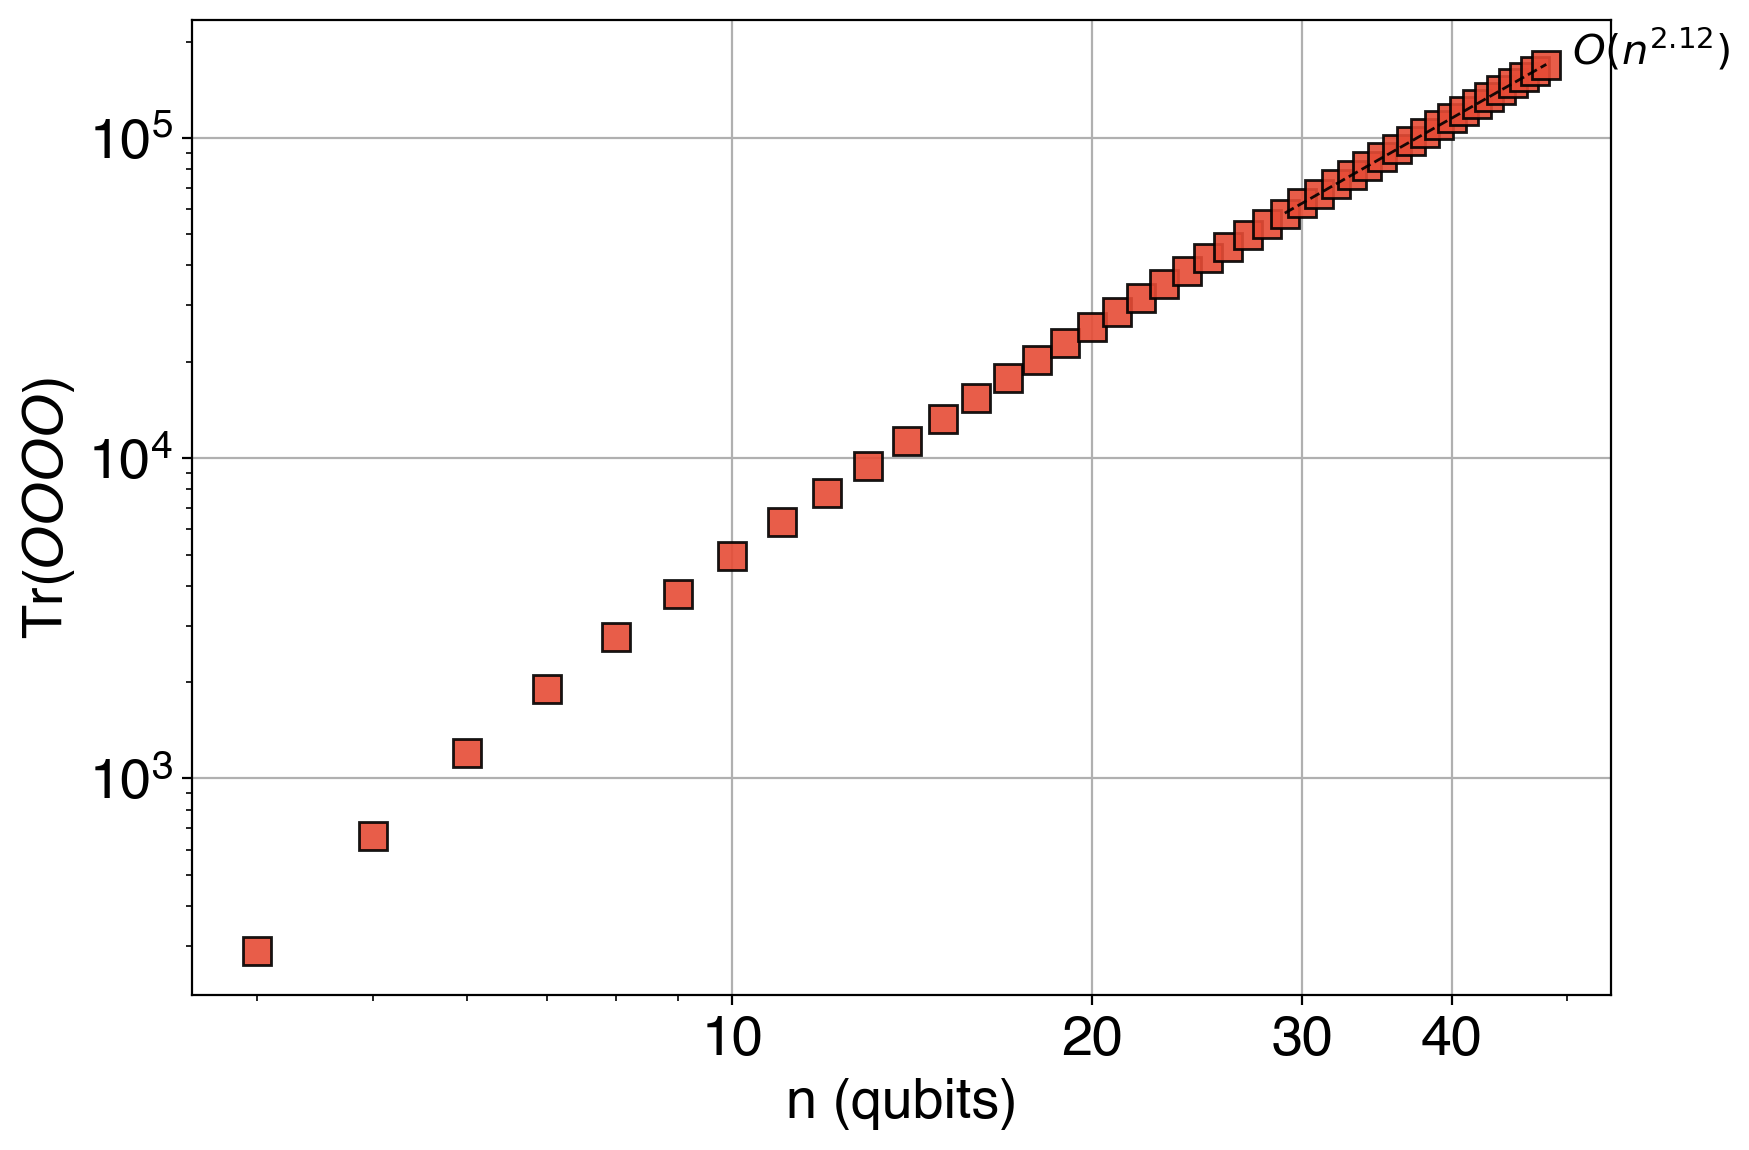

In [19]:
with open('norm4.pkl', 'rb') as f:
    norm4_list = pickle.load(f)

fig, ax = plt.subplots(1, 1, figsize=(9, 6), layout='tight')
ax.plot(n_list, norm4_list, 's', label='Norm4')
plot_fit(ax, n_list[25:], norm4_list[25:], var='n', offset=1.05)
ax.set_xlabel(rf'n (qubits)')
ax.set_ylabel(rf'Tr($OOOO$)')
ax.loglog(); ax.grid()
# ax.set_xticks(n_list)
ax.set_xticks([10, 20, 30, 40])
ax.get_xaxis().set_major_formatter(mpl.ticker.ScalarFormatter())
plt.savefig(rf'../figs/nested_commutator_4norm.pdf', dpi=150, bbox_inches='tight')

## Ising

In [508]:
from qiskit.quantum_info import random_statevector

prefix, suffix = 'TFI', 'n'
dir = '../figs'
J, h = 1, 0.5
eps = 1e-3
n_sample = 20
n_round = 10
n_max = 10
n_list = np.arange(4, n_max+1)

data_keys = ['emp_worst', 'emp_averg', 'emp_averg_std', 'emp_averg_magn', 'emp_averg_corr', 'emp_averg_magn_std', 'emp_averg_corr_std', 'bnd_worst', 'bnd_averg', 'bnd_averg_magn', 'bnd_averg_corr', 'n']
# data = dict([(k, {key: [] for key in ['emp', 'bnd']} ) for k in ob_keys])
data = dict([(k, []) for k in data_keys])
data['n'] = n_list

In [25]:
# emp_worst_list, emp_averg_list, emp_obser_list, emp_corre_list = [], [], [], []
# bnd_worst_list, bnd_averg_list, bnd_averg_magn_list = [], [], []

for n in n_list:
    print(f'------ n = {n} ------')
    tfi = TF_Ising_1d(n=n, J=-J, h=-h)
    t = n
    corr_op = SparsePauliOp.from_sparse_list([('ZZ', [i,i+1], 1/(n-1)) for i in range(0, n-1)], num_qubits=n).to_matrix()
    magn_op = SparsePauliOp.from_sparse_list([('Z', [i], 1/n) for i in range(0, n)], num_qubits=n).to_matrix()
    par_group = [h.to_matrix(True) for h in tfi.ham_parity]
    xyz_group = [h.to_matrix(True) for h in tfi.ham_xyz]

    # rand_states = [random_statevector(2**n) for _ in range(n_sample)]
    # print(rand_states)
    exact_U = scipy.linalg.expm(-1j * t * sum([h.to_matrix() for h in tfi.ham_parity]))
    assert np.allclose(exact_U, scipy.linalg.expm(-1j * t * sum([h.to_matrix() for h in tfi.ham_xyz])))

    empirical_worst_op_error_r = partial(empirical_error, h_list=par_group, t=t, exact_U=exact_U, type='worst_empirical')
    bound_worst_op_error_r = partial(empirical_error, h_list=par_group, t=t, exact_U=exact_U, type='worst_bound')
    bound_averg_op_error_r = partial(empirical_error, h_list=par_group, t=t, exact_U=exact_U, type='average_bound')
    empirical_averg_st_error_r = partial(empirical_error, h_list=par_group, t=t, exact_U=exact_U, rand_states=rand_states, type='average_empirical')
    bound_averg_magn_op_error_r = partial(empirical_error, h_list=par_group, t=t, exact_U=exact_U, ob=magn_op, type='average_ob_bound')
    bound_averg_corr_op_error_r = partial(empirical_error, h_list=par_group, t=t, exact_U=exact_U, ob=corr_op, type='average_ob_bound')
    # empirical_error_r(10)
    r_start, r_end = 10, 1000

    data['emp_worst'].append(binary_search_r(r_start, r_end, eps, empirical_worst_op_error_r, verbose=False))
    data['bnd_worst'].append(binary_search_r(r_start, r_end, eps, bound_worst_op_error_r, verbose=False))
    data['bnd_averg'].append(binary_search_r(r_start, r_end, eps, bound_averg_op_error_r, verbose=False))
    data['bnd_averg_magn'].append(binary_search_r(r_start, r_end, eps, bound_averg_magn_op_error_r, verbose=False))
    data['bnd_averg_corr'].append(binary_search_r(r_start, r_end, eps, bound_averg_corr_op_error_r, verbose=False))

    magn_list, corr_list, stat_list = [], [], []
    print('----empirical observable error----')
    for _ in range(n_round):
        rand_states = [random_statevector(2**n) for _ in range(n_sample)]
        empirical_averg_mg_error_r = partial(empirical_error, h_list=par_group, t=t, exact_U=exact_U, rand_states=rand_states, ob=magn_op, type='observable_empirical')
        empirical_averg_zz_error_r = partial(empirical_error, h_list=par_group, t=t, exact_U=exact_U, rand_states=rand_states, ob=corr_op, type='observable_empirical')
        empirical_averg_st_error_r = partial(empirical_error, h_list=par_group, t=t, exact_U=exact_U, rand_states=rand_states, type='average_empirical')
        magn_list.append(binary_search_r(r_start, r_end, eps, empirical_averg_mg_error_r, verbose=False))
        corr_list.append(binary_search_r(r_start, r_end, eps, empirical_averg_zz_error_r, verbose=False))
        stat_list.append(binary_search_r(r_start, r_end, eps, empirical_averg_st_error_r, verbose=False))

    data['emp_averg'].append(np.mean(stat_list))
    data['emp_averg_std'].append(np.std(stat_list))
    data['emp_averg_magn'].append(np.mean(magn_list))
    data['emp_averg_corr'].append(np.mean(corr_list))
    data['emp_averg_magn_std'].append(np.std(magn_list))
    data['emp_averg_corr_std'].append(np.std(corr_list))
# save to csv
pd.DataFrame(data).to_csv(f'./data/{prefix}_data_max={n_max}_sample={n_sample}_{suffix}.csv', index=False)

------ n = 4 ------
----binary search r----
----binary search r----
----binary search r----
----binary search r----
----binary search r----
----empirical observable error----
----binary search r----
----binary search r----
----binary search r----
----binary search r----
----binary search r----
----binary search r----
----binary search r----
----binary search r----
----binary search r----
----binary search r----
----binary search r----
----binary search r----
----binary search r----
----binary search r----
----binary search r----
----binary search r----
----binary search r----
----binary search r----
----binary search r----
----binary search r----
----binary search r----
----binary search r----
----binary search r----
----binary search r----
----binary search r----
----binary search r----
----binary search r----
----binary search r----
----binary search r----
----binary search r----
------ n = 5 ------
----binary search r----
----binary search r----
----binary search r----
----binary se

a_em: 2.0743540938135485; b_em: 2.3724194374824585
a_em: 1.8032006712993247; b_em: 2.6565918449662647
a_em: 1.8113313309484276; b_em: 1.9121225326216256
a_em: 1.608208929337234; b_em: 2.9718557503183525


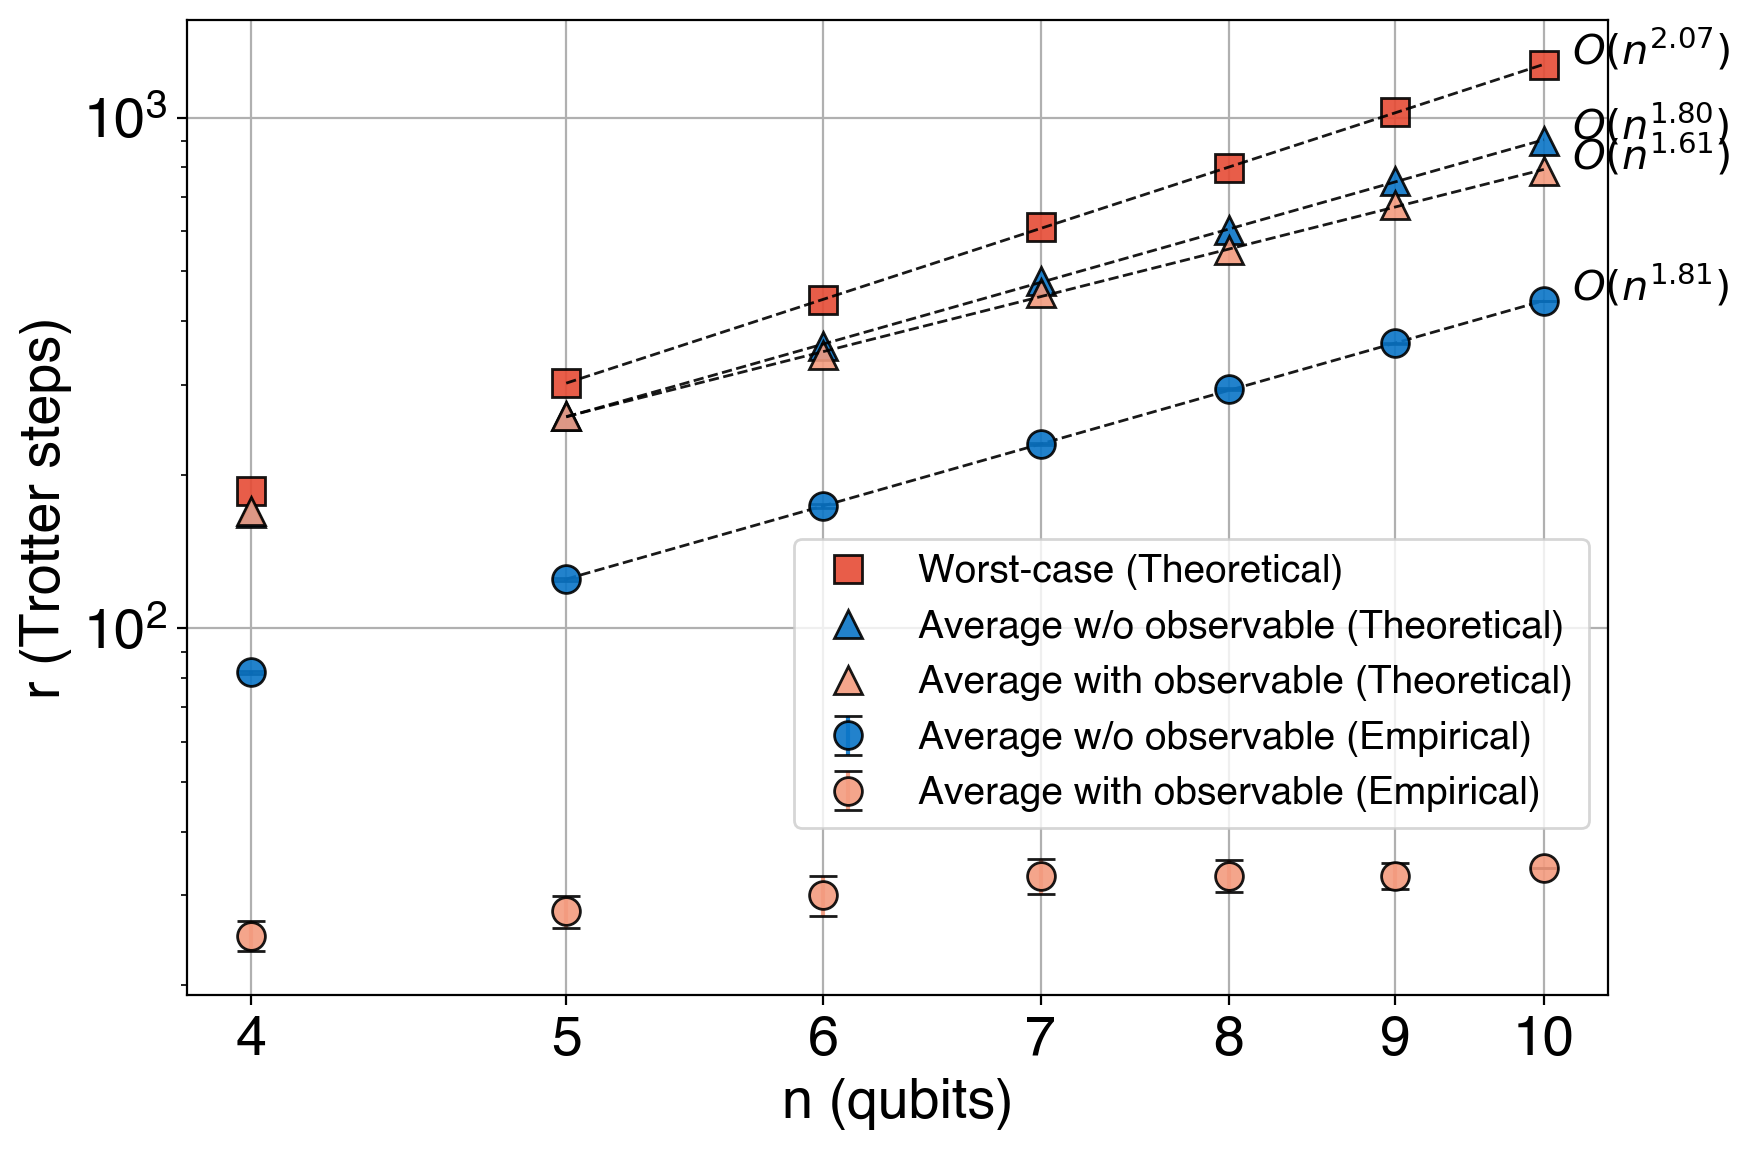

In [509]:
data = pd.read_csv(f'./data/{prefix}_data_max={n_max}_sample={n_sample}_{suffix}.csv')

fig, ax = plt.subplots(1, 1, figsize=(9, 6), layout='tight')
ax.plot(n_list, data['bnd_worst'], 's', label='Worst-case (Theoretical)')
# ax.plot(n_list, data['bnd_averg_corr'], '^', label='Our observable average bound (Correlation)')
ax.plot(n_list, data['bnd_averg'], '^', label='Average w/o observable (Theoretical)', color="#0A75C7")
ax.plot(n_list, data['bnd_averg_magn'], '^', label='Average with observable (Theoretical)', color="#F39B7FFF")
# ax.plot(n_list, data['emp_worst'], 'o', label='Empirical worst (spectral norm)')
# ax.plot(n_list, data['emp_averg'], 'o', label='Empirical Haar average (l2 norm)')
ax.errorbar(n_list, data['emp_averg'], data['emp_averg_std'], fmt='o', label='Average w/o observable (Empirical)', capsize=5, color="#0A75C7")
# ax.plot(n_list, data['emp_averg_magn'], '*', label='Empirical observable (Magnetization)', markersize=12)
ax.errorbar(n_list, data['emp_averg_magn'], data['emp_averg_magn_std'], fmt='o', label='Average with observable (Empirical)', capsize=5, color="#F39B7FFF")
# ax.errorbar(n_list, data['emp_averg_corr'], data['emp_averg_corr_std'], fmt='*', label='Empirical average (Correlation)', capsize=5)
# ax.plot(n_list, data['emp_averg_corr'], '*', label='Empirical average (Correlation)', markersize=12)

# plot_fit(ax, n_list[1:], data['emp_worst'][1:], var=suffix, offset=1.05)
plot_fit(ax, n_list[1:], data['bnd_worst'][1:], var=suffix, offset=1.02)
plot_fit(ax, n_list[1:], data['bnd_averg'][1:], var=suffix, offset=1.02)
plot_fit(ax, n_list[1:], data['emp_averg'][1:], var=suffix, offset=1.02)
plot_fit(ax, n_list[1:], data['bnd_averg_magn'][1:], var=suffix, offset=1.02)
# ax.set_title(rf'{prefix} (J={J}, h={h}), $\epsilon = {eps}$, $t = n$')
ax.set_xlabel(rf'n (qubits)')
ax.set_ylabel(rf'r (Trotter steps)')
ax.loglog(); ax.grid()
ax.set_xticks(n_list)
ax.get_xaxis().set_major_formatter(mpl.ticker.ScalarFormatter())
# ax.legend()
plt.rc('legend', fontsize=MEDIUM_SIZE-1) 
ax.legend(loc='center right', bbox_to_anchor=(1.0, 0.32))
fig.savefig(f'{dir}/{prefix}_max={n_list[-1]}_{suffix}_sample={n_sample}.pdf', dpi=150, bbox_inches='tight')

In [565]:
M = exact_U - appro_U
# np.linalg.eigh(M)
print('spectral norm by definition: ', sqrt(np.linalg.eigh(M.conj().T @ M)[0][-1]))
print('largest eigenval: ', np.linalg.eigh(M)[0][-1])
# np.linalg.norm(np.linalg.eigh(exact_U - appro_U)[1][-1], ord=2)
# np.linalg.norm(exact_U - appro_U, ord=-2)
U, S, V = np.linalg.svd(M)
print('largest singular value: ', S[0])
# print(V[0])
norm(V[0])
print(norm(M @ V[0].conj().T))
print(norm(M @ V[0]))
# print(norm(M @ np.linalg.eigh(M)[1][-1]).conj().T)
print('spectral norm by numpy: ', np.linalg.norm(M, ord=2))
# sorted(S)

spectral norm by definition:  (0.0007450431146314099+0j)
largest eigenval:  0.0007284601734476099
largest singular value:  0.0007450431146314102
0.0007450431146314103
0.00064918643400659
spectral norm by numpy:  0.0007450431146314098


In [570]:
test_rand = random_statevector(2**1).data
print(test_rand)
print(test_rand.conj().T )
print(np.array([[3, -1], [2, 1]]) @ test_rand)
print(np.array([[3, -1], [2, 1]]) @ test_rand.conj().T)
print(test_rand.conj().T @ np.array([[3, -1], [2, 1]]) @ test_rand)
print(test_rand @ np.array([[3, -1], [2, 1]]) @ test_rand.conj().T)
print(np.linalg.norm(test_rand), np.linalg.norm(test_rand.conj().T))

[ 0.310236+0.175993j -0.881979-0.308046j]
[ 0.310236-0.175993j -0.881979+0.308046j]
[ 1.812688+0.836026j -0.261507+0.04394j ]
[ 1.812688-0.836026j -0.261507-0.04394j ]
(0.9266042602801047-0.17896549010504967j)
(0.9266042602801047+0.17896549010504967j)
0.9999999999999999 0.9999999999999999


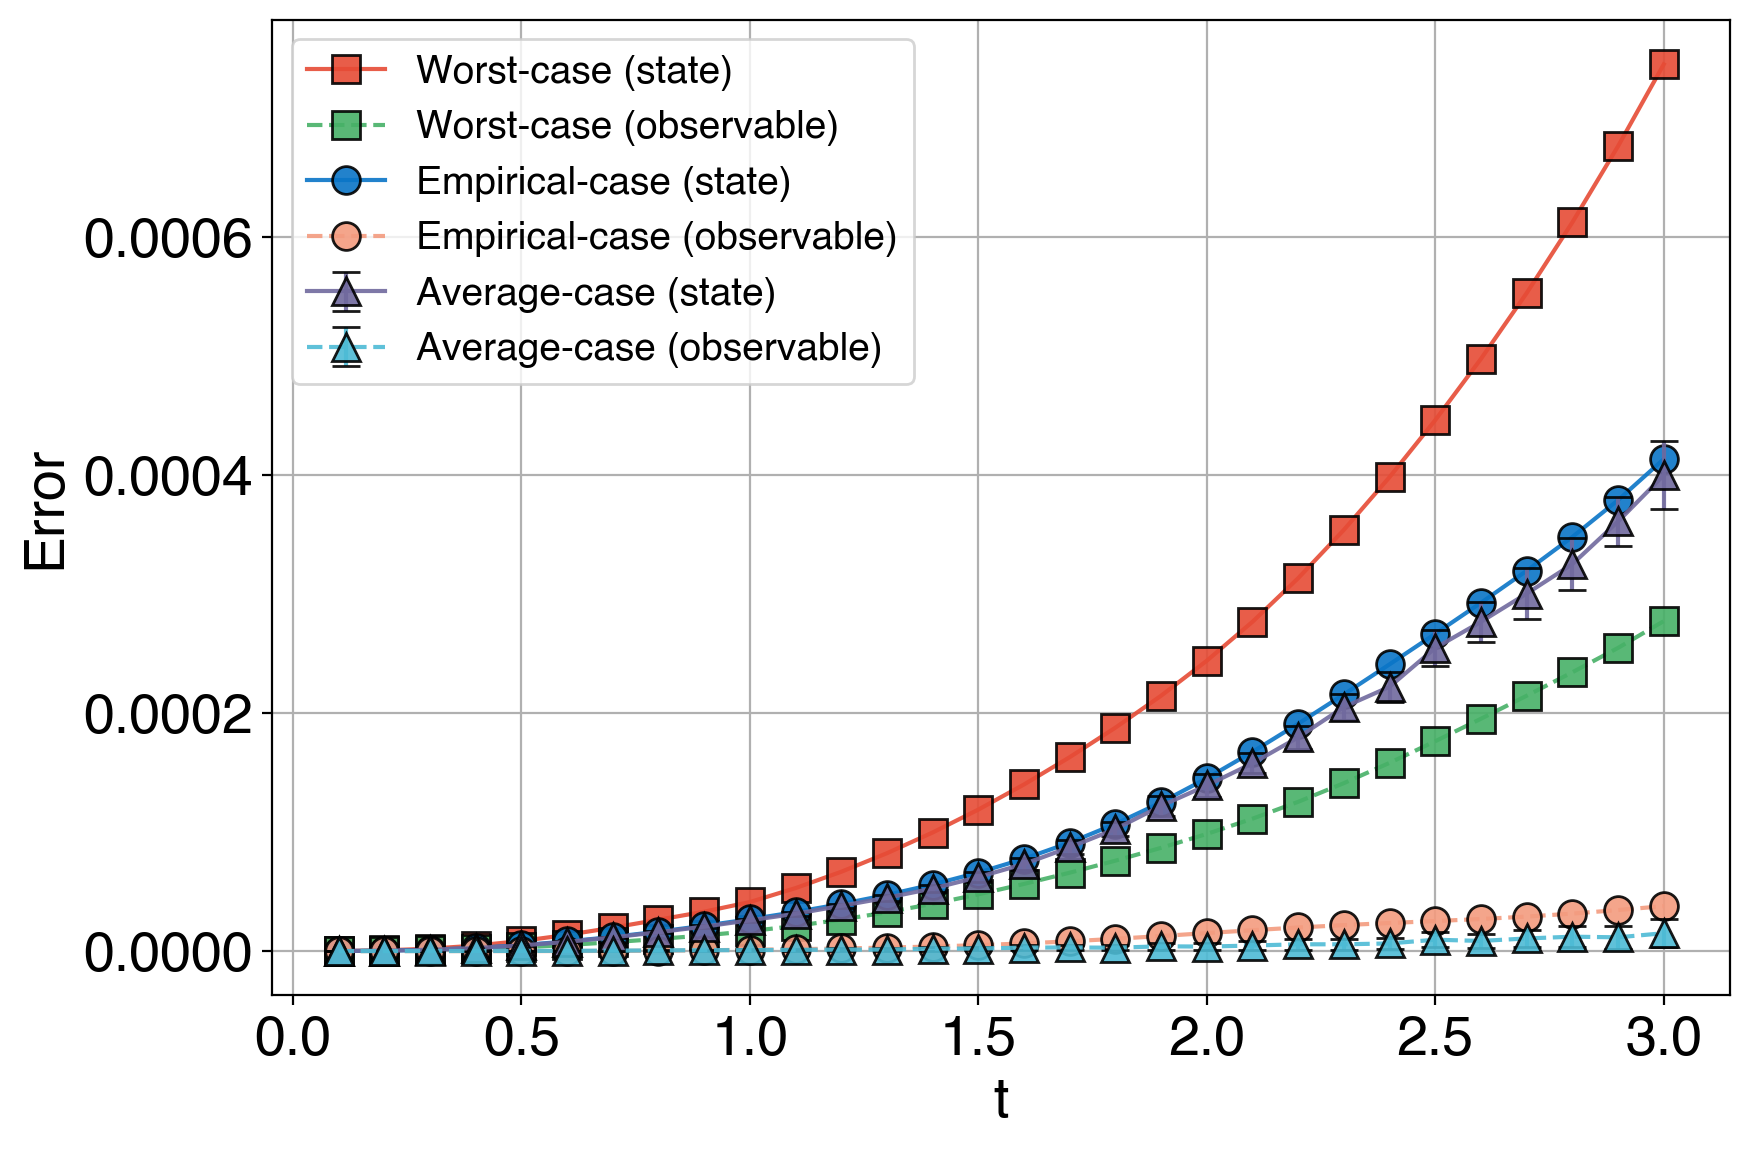

In [601]:
from fermion_ham import *

from openfermion import MolecularData
from openfermion.transforms import get_fermion_operator, jordan_wigner
from openfermion.linalg import get_ground_state, get_sparse_operator
from qiskit.quantum_info import random_statevector, Statevector

prefix, suffix = 'Ising', 't'
dir = '../figs'

r = 100
n_sample = 50
t_list = np.linspace(0.1, 3, 30)

keys = ['worst_err', 'averg_err', 'averg_err_std', 'typic_err', 'worst_ob_err', 'averg_ob_err', 'averg_ob_err_std', 'typic_ob_err','t']
data = dict([(k, []) for k in keys])
data['t'] = t_list

n = 6
J, h = 1, 0.5   
tfi = TF_Ising_1d(n=n, J=-J, h=-h)
# init_st = Statevector.from_label('-'*n).data
init_st = get_ground_state(tfi.ham.to_matrix())[1]
init_st = random_statevector(2**n).data
# init_st = np.linalg.eigh(exact_U - pf_AB(par_group, 3, r, ord=2))[1][-1]

for t in t_list:
    # print(f'------ t = {t} ------')
    magn_op = SparsePauliOp.from_sparse_list([('Z', [i], 1/n) for i in range(0, n)], num_qubits=n).to_matrix()
    corr_op = SparsePauliOp.from_sparse_list([('ZZ', [i,i+1], 1/(n-1)) for i in range(0, n-1)], num_qubits=n).to_matrix()
    ob = magn_op
    par_group = [h.to_matrix(True) for h in tfi.ham_parity]
    xyz_group = [h.to_matrix(True) for h in tfi.ham_xyz]
    appro_U = pf_AB(par_group, t, r, ord=2)
    # init_st = np.linalg.eigh(exact_U - appro_U)[1][-1]

    # rand_states = [random_statevector(2**n) for _ in range(n_sample)]
    # print(rand_states)
    exact_U = scipy.linalg.expm(-1j * t * sum([h.to_matrix() for h in tfi.ham_parity]))
    assert np.allclose(exact_U, scipy.linalg.expm(-1j * t * sum([h.to_matrix() for h in tfi.ham_xyz])))
    rand_states = [random_statevector(len(exact_U)) for _ in range(n_sample)]
    M = exact_U - appro_U
    U, S, V = np.linalg.svd(M)
    # init_st = V[0].conj().T
    # init_st = np.linalg.eigh(exact_U - appro_U)[1][-1]
    # init_st = np.linalg.eigh(M.conj().T @ M)[1][-1]
    # op_norm = sqrt(np.linalg.eigh(M.conj().T @ M)[0][-1])
    # print('operator norm: ', op_norm, np.linalg.norm(M, ord=2))
    # op_norm = np.linalg.norm(tfi.ham.to_matrix(), ord=2)
    # ob = tfi.ham.to_matrix()/np.linalg.norm(tfi.ham.to_matrix(), ord=2)

    data['worst_err'].append(np.linalg.norm(exact_U - appro_U, ord=2))
    averg_st_err = [np.linalg.norm(exact_U @ state.data - appro_U @ state.data) for state in rand_states]
    # print(averg_ob_err)
    data['averg_err'].append(np.mean(averg_st_err))
    data['averg_err_std'].append(np.std(averg_st_err))
    data['typic_err'].append(np.linalg.norm(exact_U @ init_st - appro_U @ init_st, ord=2))
    # exact_st = exact_U @ init_st
    # appro_st = appro_U @ init_st
    # data['typic_err'].append(0.5* np.linalg.norm(np.outer(exact_st.conj().T, exact_st) - np.outer(appro_st.conj().T, appro_st), ord='nuc'))
    # print(ground_state.conj().T @ exact_U.conj().T @ h_ob @ exact_U @ ground_state)

    data['worst_ob_err'].append( np.linalg.norm(exact_U.conj().T @ ob @ exact_U - appro_U.conj().T @ ob @ appro_U, ord=2)    )
    averg_ob_err = [np.abs(state.data @ exact_U.conj().T @ ob @ exact_U @ state.data.conj().T - state.data @ appro_U.conj().T @ ob @ appro_U @ state.data.conj().T) for state in rand_states]
    data['averg_ob_err'].append(np.mean(averg_ob_err))
    data['averg_ob_err_std'].append(np.std(averg_ob_err))
    data['typic_ob_err'].append( np.abs(init_st.conj().T @ exact_U.conj().T @ ob @ exact_U @ init_st - init_st.conj().T @ appro_U.conj().T @ ob @ appro_U @ init_st))
    # print("energy: ", init_st.conj().T @ exact_U.conj().T @ ob @ exact_U @ init_st, init_st.conj().T @ appro_U.conj().T @ ob @ appro_U @ init_st)

fig, ax = plt.subplots(1, 1, figsize=(9, 6), layout='tight')
ax.plot(data['t'], data['worst_err'], 's-', label='Worst-case (state)')
ax.plot(data['t'], data['worst_ob_err'], 's--', label='Worst-case (observable)')
ax.plot(data['t'], data['typic_err'], 'o-', label='Empirical-case (state)')
ax.plot(data['t'], data['typic_ob_err'], 'o--', label='Empirical-case (observable)')

# ax.plot(data['t'], data['averg_err'], '^-', label='Average-case (state)')
# ax.plot(data['t'], data['averg_ob_err'], '^--', label='Average-case (observable)')
ax.errorbar(data['t'], data['averg_err'], data['averg_err_std'], fmt='^-', label='Average-case (state)', capsize=5)
ax.errorbar(data['t'], data['averg_ob_err'], data['averg_ob_err_std'], fmt='^--', label='Average-case (observable)', capsize=5)

# ax.set_title(rf'H2 chain, init d={d}, H=H2(2d), ob=H2(d), r={r}')
ax.set_xlabel(rf't')
ax.set_ylabel(rf'Error')
ax.grid()
# ax.loglog()
ax.legend()
fig.savefig(f'{dir}/{prefix}_n={n}_r={r}_sample={n_sample}.pdf', dpi=150, bbox_inches='tight')

## Chemistry

In [449]:
np.outer(exact_st.conj().T, exact_st) - np.outer(appro_st.conj().T, appro_st)
np.linalg.norm(np.outer(exact_st.conj().T, exact_st) - np.outer(appro_st.conj().T, appro_st), ord='nuc')

0.0010610673174982974

# pstr: 62, ['IIIIII', 'ZIIIII', 'YZZZYI', 'XZZZXI', 'IZIIII', 'IYZZZY', 'IXZZZX', 'IIZIII', 'IIIZII', 'IIIIZI', 'IIIIIZ', 'ZZIIII', 'YIZZYI', 'XIZZXI', 'YXXYII', 'YYXXII', 'XXYYII', 'XYYXII', 'ZYZZZY', 'ZXZZZX', 'YXIIXY', 'YYIIXX', 'XXIIYY', 'XYIIYX', 'ZIZIII', 'YZIZYI', 'XZIZXI', 'ZIIZII', 'YZZIYI', 'XZZIXI', 'YZYYZY', 'YZYXZX', 'XZXYZY', 'XZXXZX', 'ZIIIZI', 'ZIIIIZ', 'YZZZYZ', 'XZZZXZ', 'IZZIII', 'IYIZZY', 'IXIZZX', 'IYXXYI', 'IYYXXI', 'IXXYYI', 'IXYYXI', 'IZIZII', 'IYZIZY', 'IXZIZX', 'IZIIZI', 'IYZZIY', 'IXZZIX', 'IZIIIZ', 'IIZZII', 'IIYXXY', 'IIYYXX', 'IIXXYY', 'IIXYYX', 'IIZIZI', 'IIZIIZ', 'IIIZZI', 'IIIZIZ', 'IIIIZZ']
# groups: 22
[[{'IIIIII': (-0.33362884012829697+0j)}, {'ZIIIII': (0.16891173410254534+0j)}, {'YZZZYI': (0.0004614778443555352+0j)}], [{'XZZZXI': (0.0004614778443555352+0j)}, {'IZIIII': (0.16891173410254526+0j)}, {'IYZZZY': (0.00046147784435555516+0j)}], [{'IXZZZX': (0.00046147784435555516+0j)}, {'IIZIII': (0.020862150051427164+0j)}, {'IIIZII': (0.02086215005142716+

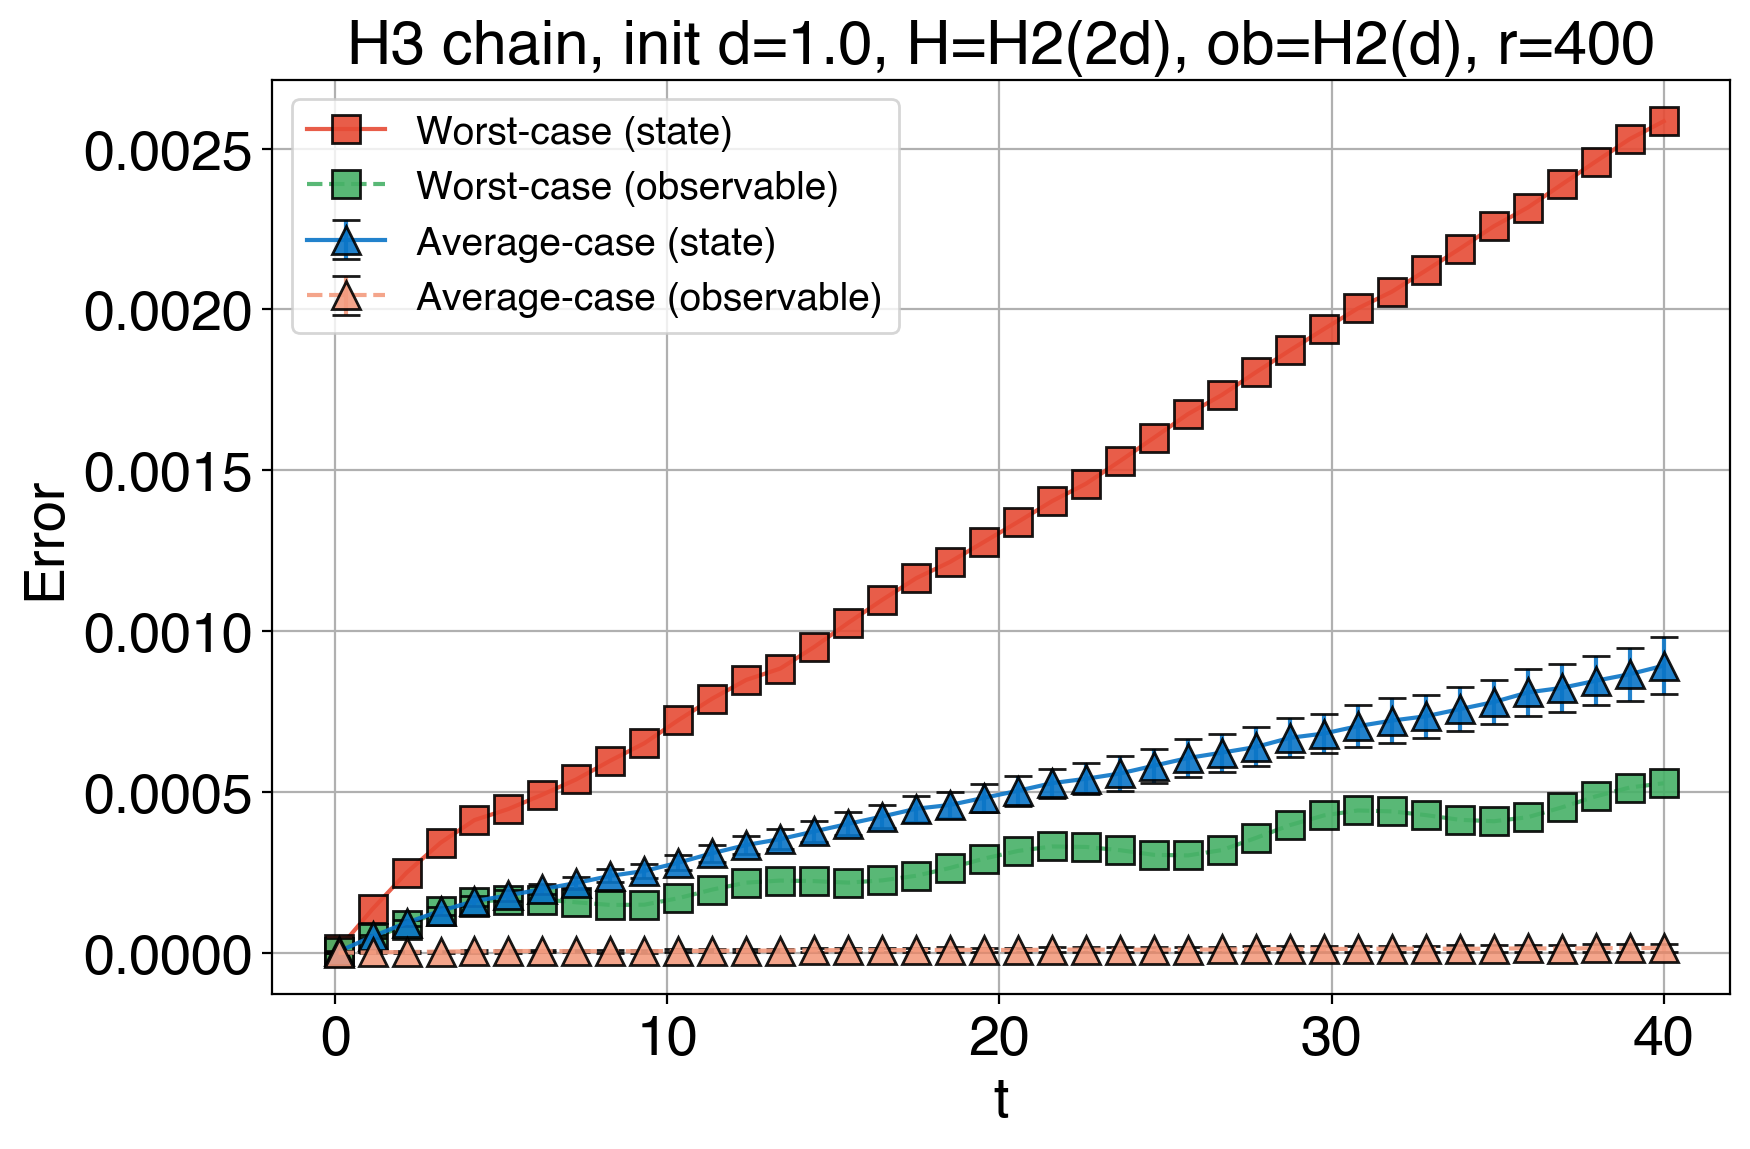

In [29]:
from fermion_ham import *

from openfermion import MolecularData
from openfermion.transforms import get_fermion_operator, jordan_wigner
from openfermion.linalg import get_ground_state, get_sparse_operator
from qiskit.quantum_info import random_statevector, Statevector

prefix, suffix = 'Chem', 't'
dir = '../figs'

d = 1.0
n_hydrogen = 3
n = n_hydrogen * 2
h2_init = hydrogen_chain_hamiltonian(n_hydrogen, d, verbose=False)
h2_finl = hydrogen_chain_hamiltonian(n_hydrogen, 2*d, verbose=False)
# print(get_ground_state(get_sparse_operator(h2_init.fermion_hamiltonian)))
# print(get_ground_state(get_sparse_operator(h2_finl.fermion_hamiltonian)))

# print(h2_init.jw)
ground_state_energy, ground_state =  get_ground_state(get_sparse_operator(h2_init.fermion_hamiltonian))
print('ground energy: ', ground_state_energy, ground_state)
# vec0 = np.array([0 for _ in range(len(ground_state))])
# vec0[-1] = 1
# ground_state = vec0/np.sqrt(2)  + ground_state / np.sqrt(2) 
# ground_state = Statevector.from_label('++++').data/np.sqrt(2)  + Statevector.from_label('1100').data / np.sqrt(2) 
# ground_state = Statevector.from_label('++++').data
# ground_state = Statevector.from_label('1'*4).data
# ground_state = random_statevector(2**4).data
init_st = ground_state.conj().T
print('init state: ', init_st)  
r = 100
n_sample = 500
t_list = np.linspace(0.1, 40, 40)

chem_keys = ['worst_err', 'averg_err', 'averg_err_std', 'typic_err', 'worst_ob_err', 'averg_ob_err', 'averg_ob_err_std', 'typic_ob_err','t']
chem_data = dict([(k, []) for k in chem_keys])
chem_data['t'] = t_list

for t in t_list:
    # print(f'------t: {t}-----')  
    r = int(10 * t)
    # print("H norm: ", np.linalg.norm(sum([h for h in h2_init.hamiltonian_list]), ord=2) )
    h_ob = sum([h for h in h2_init.hamiltonian_list])/np.linalg.norm(sum([h for h in h2_init.hamiltonian_list]), ord=2) 
    # h_ob =  SparsePauliOp.from_sparse_list([('ZZ', [i, i+1], 1/(n-1)) for i in range(0, n-1)], num_qubits=n).to_matrix()
    # h_ob =  SparsePauliOp.from_sparse_list([('Y', [i], 1/n) for i in range(0, n)], num_qubits=n).to_matrix()
    h_list = h2_finl.qubit_terms
    exact_U = scipy.linalg.expm(-1j * t * sum([h  for h in h2_finl.hamiltonian_list]))
    appro_U = pf_AB(h_list, t, r, ord=2)
    rand_states = [random_statevector(len(exact_U)) for _ in range(n_sample)]
    M = exact_U - appro_U
    U, S, V = np.linalg.svd(M)
    # init_st = V[0].conj().T

    chem_data['worst_err'].append(2*np.linalg.norm(exact_U - appro_U, ord=2))
    averg_st_err = [np.linalg.norm(np.outer(exact_U @ state.data.conj().T , (exact_U @ state.data.conj().T).conj().T) - np.outer(appro_U @ state.data.conj().T, (appro_U @ state.data.conj().T).conj().T), ord='nuc') for state in rand_states]
    # averg_st_err = [np.linalg.norm(exact_U @ state.data.conj().T - appro_U @ state.data.conj().T) for state in rand_states]
    # print(averg_ob_err)
    chem_data['averg_err'].append(np.mean(averg_st_err))
    chem_data['averg_err_std'].append(np.std(averg_st_err))
    # chem_data['typic_err'].append(np.linalg.norm(exact_U @ init_st - appro_U @ init_st))
    exact_st = exact_U @ init_st
    appro_st = appro_U @ init_st
    chem_data['typic_err'].append(np.linalg.norm(np.outer(exact_st, exact_st.conj().T) - np.outer(appro_st, appro_st.conj().T), ord='nuc'))
    # print(ground_state.conj().T @ exact_U.conj().T @ h_ob @ exact_U @ ground_state)

    chem_data['worst_ob_err'].append(np.linalg.norm(exact_U.conj().T @ h_ob @ exact_U - appro_U.conj().T @ h_ob @ appro_U, ord=2))
    averg_ob_err = [np.abs(state.data.conj().T @ exact_U.conj().T @ h_ob @ exact_U @ state.data - state.data.conj().T @ appro_U.conj().T @ h_ob @ appro_U @ state.data) for state in rand_states]
    chem_data['averg_ob_err'].append(np.mean(averg_ob_err))
    chem_data['averg_ob_err_std'].append(np.std(averg_ob_err))
    chem_data['typic_ob_err'].append( np.abs(init_st.conj().T @ exact_U.conj().T @ h_ob @ exact_U @ init_st - init_st.conj().T @ appro_U.conj().T @ h_ob @ appro_U @ init_st))
    print("energy: ", init_st.conj().T @ exact_U.conj().T @ h_ob @ exact_U @ init_st, init_st.conj().T @ appro_U.conj().T @ h_ob @ appro_U @ init_st)

fig, ax = plt.subplots(1, 1, figsize=(9, 6), layout='tight')
ax.plot(chem_data['t'], chem_data['worst_err'], 's-', label='Worst-case (state)')
ax.plot(chem_data['t'], chem_data['worst_ob_err'], 's--', label='Worst-case (observable)')
# ax.plot(chem_data['t'], chem_data['typic_err'], 'o-', label='Empirical-case (state)')
# ax.plot(chem_data['t'], chem_data['typic_ob_err'], 'o--', label='Empirical-case (observable)')

# ax.plot(chem_data['t'], chem_data['averg_err'], '^-', label='Average-case (state)')
# ax.plot(chem_data['t'], chem_data['averg_ob_err'], '^--', label='Average-case (observable)')
ax.errorbar(chem_data['t'], chem_data['averg_err'], chem_data['averg_err_std'], fmt='^-', label='Average-case (state)', capsize=5)
ax.errorbar(chem_data['t'], chem_data['averg_ob_err'], chem_data['averg_ob_err_std'], fmt='^--', label='Average-case (observable)', capsize=5)

ax.set_title(rf'H{n_hydrogen} chain, init d={d}, H=H2(2d), ob=H2(d), r={r}')
ax.set_xlabel(rf't')
ax.set_ylabel(rf'Error')
ax.grid()
# ax.loglog()
ax.legend()
fig.savefig(f'{dir}/{prefix}_d={d}_r={r}_n={n}_sample={n_sample}.pdf', dpi=150, bbox_inches='tight')

In [105]:
chem_data['worst_err']
chem_data['typic_err']

[2.787157485395818e-10,
 1.343747327863739e-07,
 8.648726051011768e-07,
 2.6366192322402064e-06,
 5.763179713933657e-06,
 1.038096432970019e-05,
 1.6419947628297348e-05,
 2.3595258626377903e-05,
 3.142362520176276e-05,
 3.926919062434682e-05,
 4.6425768467420384e-05,
 5.2249497217252736e-05,
 5.6370626308559964e-05,
 5.90335668415512e-05,
 6.15863596220156e-05,
 6.683390337199177e-05,
 7.829849191539457e-05,
 9.818445410700423e-05,
 0.0001264106148599493,
 0.00016151224257676105,
 0.0002015626596601415,
 0.00024449991618605234,
 0.0002882223775526305,
 0.000330684804480451,
 0.00037005343193484186,
 0.00040492624000216084,
 0.0004346136913738511,
 0.0004594644240184114,
 0.00048118754955014584,
 0.0005030481248814664]

## Ising model

Text(0.5, 0.98, 'Observable evolution')

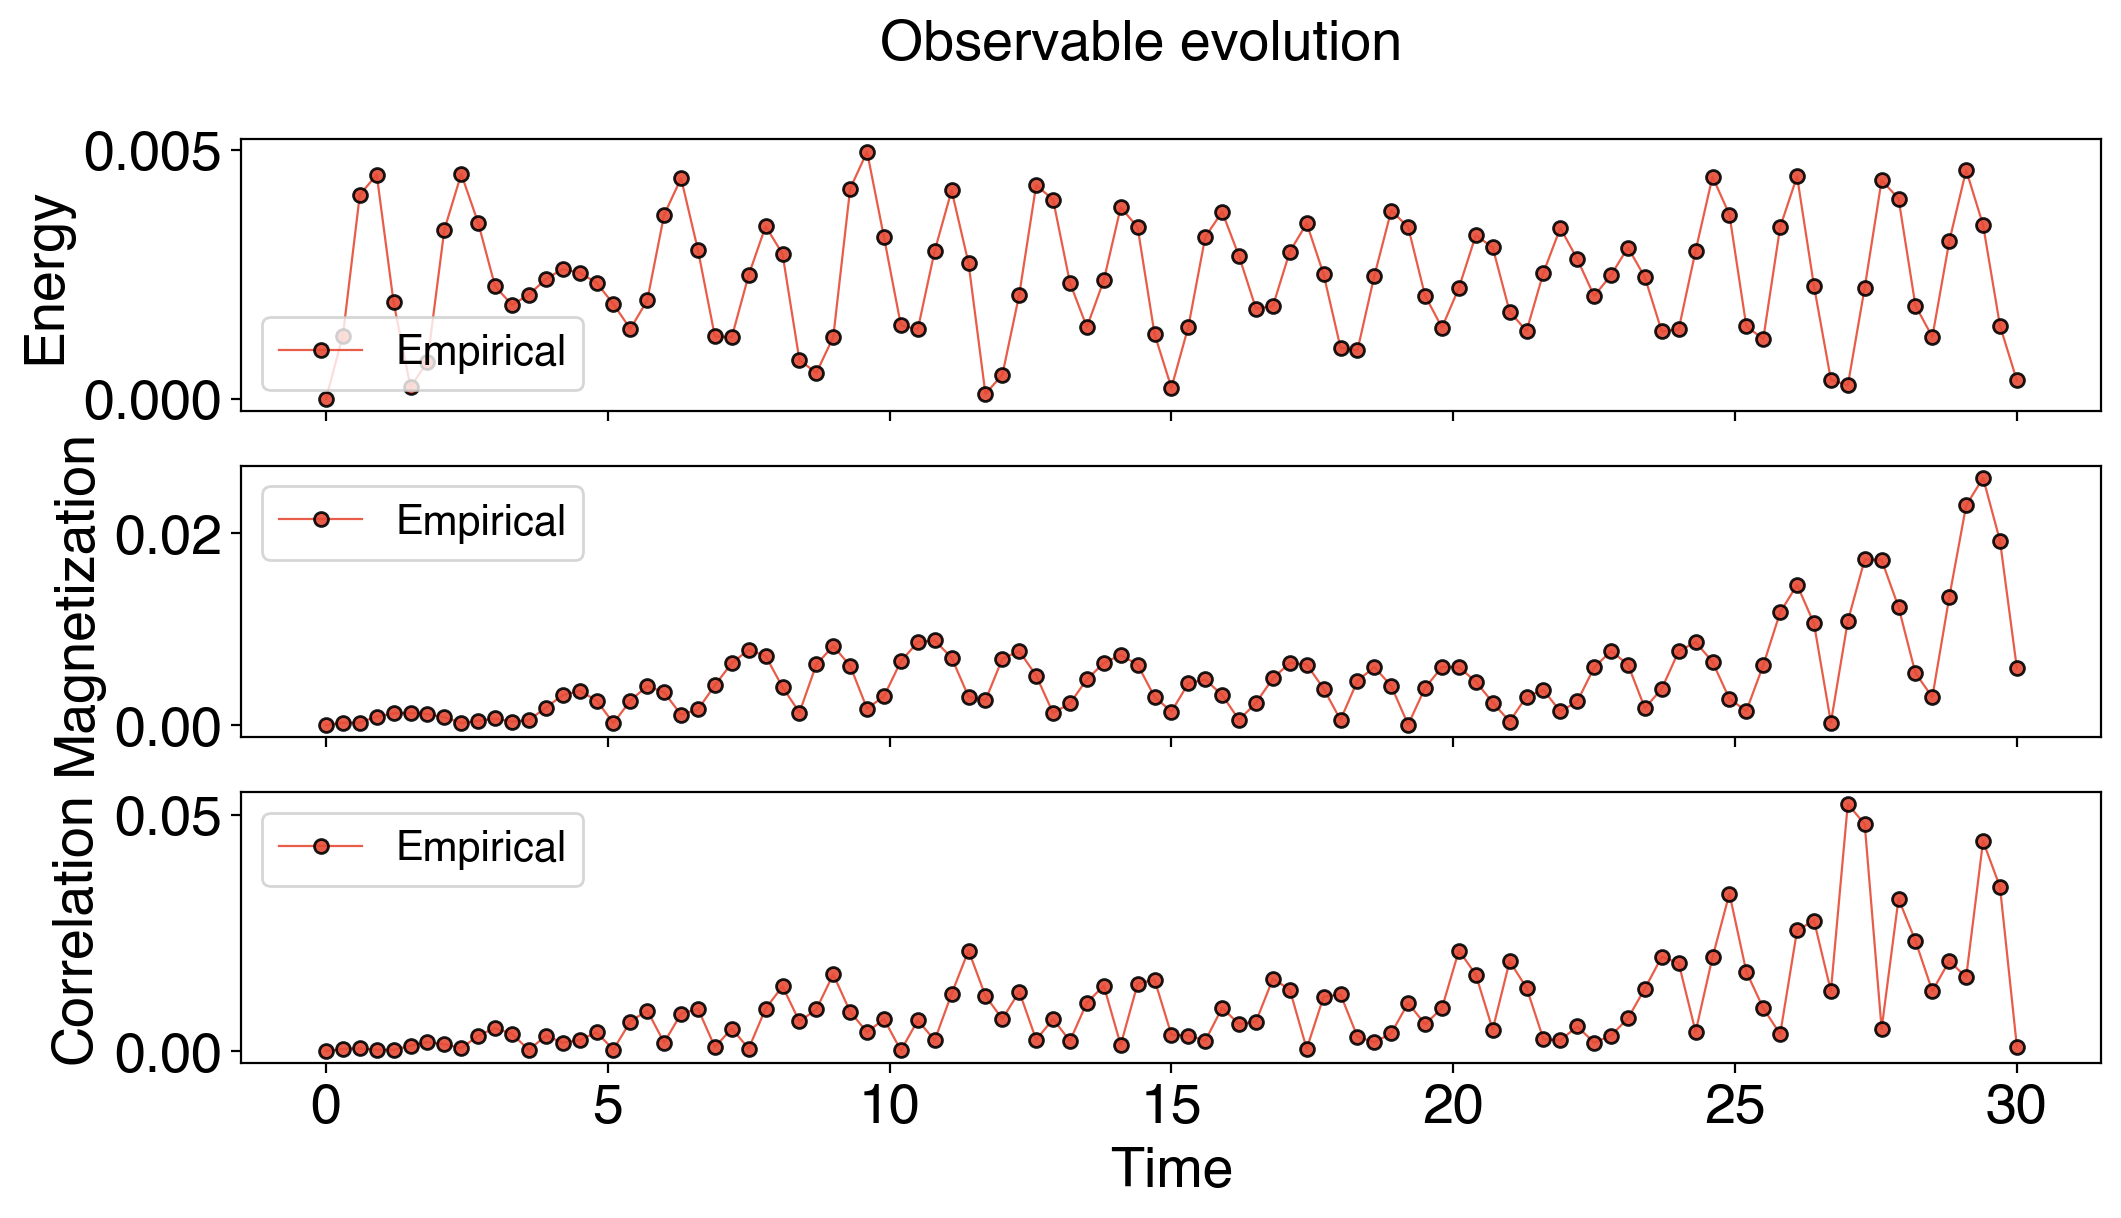

In [325]:
from qiskit.quantum_info import SparsePauliOp
from math import sin, cos


def get_hamiltonian(L, J, h, alpha=0):

    # List of Hamiltonian terms as 3-tuples containing
    # (1) the Pauli string,
    # (2) the qubit indices corresponding to the Pauli string,
    # (3) the coefficient.
    ZZ_tuples = [("ZZ", [i, i + 1], -J) for i in range(0, L - 1)]
    Z_tuples = [("Z", [i], -h * sin(alpha)) for i in range(0, L)]
    X_tuples = [("X", [i], -h * cos(alpha)) for i in range(0, L)]

    # We create the Hamiltonian as a SparsePauliOp, via the method
    # `from_sparse_list`, and multiply by the interaction term.
    hamiltonian = SparsePauliOp.from_sparse_list([*ZZ_tuples, *Z_tuples, *X_tuples], num_qubits=L)
    return hamiltonian.simplify()

from math import pi

L = 5
H = get_hamiltonian(L=L, J=0.2, h=1.0, alpha=pi / 8)

H_array = H.to_matrix()
# H

from qiskit.quantum_info import Statevector
from qiskit_algorithms import TimeEvolutionProblem
from qiskit_algorithms import TrotterQRTE
from qiskit.primitives import Estimator
from qiskit.synthesis import ProductFormula, SuzukiTrotter

# final_time = 1.6

# # First spin up, second spin down
# # (remember that the labels are interpreted from right to left)
# initial_state = Statevector.from_label("10")

# problem = TimeEvolutionProblem(H, initial_state=initial_state, time=final_time)

num_timesteps = 100
trotter = TrotterQRTE(product_formula=SuzukiTrotter(order=2), num_timesteps=num_timesteps, estimator=Estimator())
print(trotter)

magnetization_op = SparsePauliOp.from_sparse_list([("Z", [i], 1.0/L) for i in range(0, L)], num_qubits=L)
correlation_op = SparsePauliOp.from_sparse_list([("ZZ", [i, i + 1], 1.0) for i in range(0, L - 1)], num_qubits=L) / (L - 1)

final_time = 30.0
initial_state = Statevector.from_label("0"*L)
initial_state = random_statevector(2**L)
problem = TimeEvolutionProblem(
    H,
    initial_state=initial_state,
    time=final_time,
    aux_operators=[H/np.linalg.norm(H_array, ord=2), magnetization_op, correlation_op],
)
result = trotter.evolve(problem)
import numpy as np

observables = np.array(np.array(result.observables)[:, :, 0])
observables.shape

import scipy as sc


# # We define a slightly denser time mesh
# exact_times = np.linspace(0, final_time, 101)

# # We compute the exact evolution using the exp
# exact_evolution = [initial_state.evolve(sc.linalg.expm(-1j * time * H_array)) for time in exact_times]
# exact_energy = np.real([sv.expectation_value(H) for sv in exact_evolution])
# exact_magnetization = np.real([sv.expectation_value(magnetization_op) for sv in exact_evolution])
# exact_correlation = np.real([sv.expectation_value(correlation_op) for sv in exact_evolution])

def exact_evolution_obs(t):
    sv = initial_state.evolve(sc.linalg.expm(-1j * t * H_array))
    exact_energy = np.real(sv.expectation_value(H/np.linalg.norm(H_array, ord=2)))
    exact_magnetization = np.real(sv.expectation_value(magnetization_op))
    exact_correlation = np.real(sv.expectation_value(correlation_op))

    return exact_energy, exact_magnetization, exact_correlation

times = np.linspace(0, final_time, num_timesteps + 1)  # includes initial state
obs_data = np.array([exact_evolution_obs(t) for t in times])
# print(obs_data)

import matplotlib.pyplot as plt

fig, axes = plt.subplots(3, figsize=(12, 6), sharex=True)
axes[0].plot(times, abs(observables[:, 0]-obs_data[:, 0]), label="Empirical", marker=".", ls="-", lw=0.8)
axes[1].plot(times, abs(observables[:, 1]-obs_data[:, 1]), label="Empirical", marker=".", ls="-", lw=0.8)
axes[2].plot(times, abs(observables[:, 2]-obs_data[:, 2]), label="Empirical", marker=".", ls="-", lw=0.8)
# axes[0].plot(exact_times, exact_energy, c="k", ls=":", label="Exact")
# axes[1].plot(exact_times, exact_magnetization, c="k", ls=":", label="Exact")
# axes[2].plot(exact_times, exact_correlation, c="k", ls=":", label="Exact")

axes[0].set_ylabel("Energy")
axes[1].set_ylabel("Magnetization")
axes[2].set_ylabel("Correlation")
axes[2].set_xlabel("Time")
axes[0].legend()
axes[1].legend()
axes[2].legend()
fig.suptitle("Observable evolution")